# Neural Differential Equations 

In this notebook we will explore Neural Differential Equations (NDEs). The goal is to teach you about the basics of Neural Differential Equations and demonstrate how they can be used to approximate dynamical systems. We will take you through one example of fitting a NDE to a Lotka-Volterra system and prepare you to apply it to another system as your project. 

## Introduction to NDEs 

* With Neural Differential Equations we try to find a way to combine knowledge that we have of systems in form of their governing equations with data-driven approximators such as ANNs

* In fact, there is an analogy between differential equations and ANNs:

* A Residual Network (ResNet) block  is defined by $$\mathbf{h}_{t+1} = \mathbf{h}_t + f(\mathbf{h}_t;\theta_t),$$ where $f$ can be any combination of other neural network layers with parameters $\theta_t$, $\mathbf{h}_t$ is the output of the previous block or layer, which also serves as the input of the ResNet block, $\mathbf{h}_{t+1}$ is its output  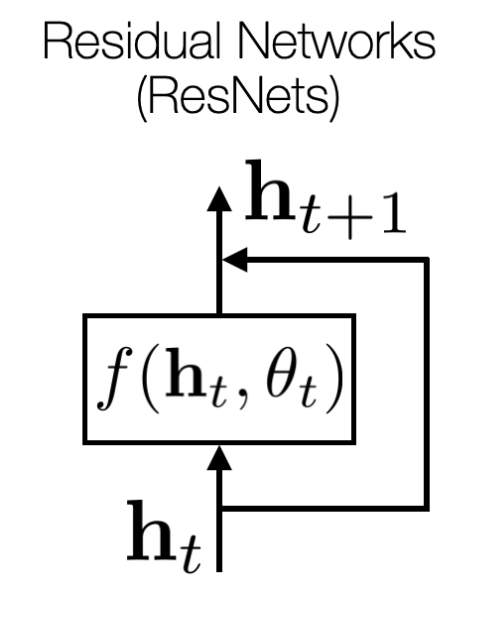

* Through their short cut connection (see the image), ResNets learn a residual (hence the name). They proved to be an effective architecture for a wide variety of problems


* Compare that to the Euler solver that discretized and solves an ODE:
$$\begin{align}  
\frac{d\mathbf{h}(t)}{dt} &= f(\mathbf{h}(t),t;\theta)\\
\mathbf{h}_{t+1} &= \Delta t f(\mathbf{h}_t, t;\theta) + \mathbf{h}_t\\
\end{align}$$

* The Euler solver and the ResNet have almost the same iteration formula 

* Hence, differential equations can be seen as a continuous time limit of ResNet ANNs
* There are several paper that use to just solve ResNets with ODE solvers, but this is not our primary interest
* We will use them to approximate dynamical systems and also a method to incorporate prior knowledge into the ML algorithm

### The Universal Differential Equations Framework

* If we can treat differential equations and ANNs so similar, we just combine them directly:

$$\frac{du}{dt} = f(u,t,U_\theta(u,t)),$$ 
where $U_{\theta}$ is some data-driven function approximator (such as an ANN)
  
![image-2.png](notebook-assets/overview2.png)

* We can integrate these Neural Differential Equations numerically, like any other differential equation we've seen before, resulting in a trajectory $$\hat{\mathbf{u}}(\mathbf{x},t;\theta)$$

* `DiffEqFlux.jl`/`DiffEqSensitivity.jl` are by far the most comprehensive implementation of this approach (of all programming languages)
* `torchdiffeq` offers some of the functionality for pyTorch
* `diffrax` offers some of the functionality for JAX

### How to Train Neural Differential Equations 

* Remember, to train an ANN we usually set a loss function $L(\theta)$ and then minimize this loss on a training data set by doing a gradient descent 

* Given some example trajectories $\mathbf{u}$ as training data, we can define a loss function $$L(\theta)= \sum_{i_t,\mathbf{x}} ( u(\mathbf{x},i_t) - \hat{\mathbf{u}}(\mathbf{x},t;\theta) )^2  + \gamma\sum_i||\theta_i||$$

* The loss function is a sum of the squared differences with an added regularization 

* What do we still need to train? 

* For regular ANNs, we would do a gradient descent by computing $\nabla_\theta L$, but here we have a slightly different situation

* Here $\hat{\mathbf{u}}(\mathbf{x},t;\theta)$ are trajectories, solutions of differential equations 

* How do we take a derivative of solutions of differential equations? 

### Adjoint Sensitivity Problems 

* These kind of problems were already solved before, e.g. by Lev Pontryagin in the 60s, analysing trajectories of rockets, or later in meteorolgy to explore the sensitivity of some climate models 

* There are many different (but vaguely similar) approaches, in Julia `DiffEqSensitivity.jl` implements many of them 




* If you want to see a complete derivation of the algorithm, [click here](notebook-assets/ReverseModeSensitivityAnalysis.html)

* With the approach from [Chen et al](https://arxiv.org/abs/1806.07366): *Reverse-mode adjoint sensitivity analysis*, we can compute derivates of the trajectories  

#### Reverse-mode Adjoint Sensitivity Problem 

In order to compute the derivatives we augment the ODE with adjoints 
\begin{align}
      \mathbf{a}(t) &= \frac{\partial \mathcal{L}}{\partial \mathbf{x}(t)}\\
      \mathbf{a}_\theta(t) &= \frac{\partial\mathcal{L}}{\partial\theta(t)} 
\end{align}

These will help us to compute the additional information that we need for the derivatives. Similar to how a traditional backpropagation traverses the chain of the ANN from the output back to the input, the appended ODE with the adjoint needs to be solved backwards in time as the initial values of the augmented dynamics are only known at the end point of the integration $t_1$. 

To compute $\frac{\partial\mathcal{L}}{\partial\theta}$, we need to solve the appended ODE that include [dynamics of the adjoints](notebook-assets/ReverseModeSensitivityAnalysis.html).

\begin{align} 
    \begin{pmatrix}
        \frac{d \mathbf{x}}{d t}\\
        \frac{d \mathbf{a}}{d t}\\ 
        \frac{d \mathbf{a}_\theta}{d t}\\
    \end{pmatrix} =
     \begin{pmatrix}
        f(\mathbf{x},t,\theta)\\
        - \mathbf{a}^T(t) \frac{\partial f(\mathbf{x}(t),t,\theta)}{\partial \mathbf{x}(t)} \\ 
        - \mathbf{a}^T(t) \frac{\partial f(\mathbf{x}(t),t,\theta)}{\partial \theta}\label{eq:node-train}
    \end{pmatrix} 
\end{align}
backwards in time from $t_1$ to $t_0$ with initial conditions $[\mathbf{x}(t_1); \frac{\partial\mathcal{L}}{\partial\mathbf{x}(t_1)}; \mathbf{0}]$ to eventually get $\frac{\partial\mathcal{L}}{\partial\theta} = \mathbf{a}_\theta(t_0)$. The partial derivatives are computed using AD. 

## The First Example 

As a first example, we look into fitting a Neural ODE to data that we generate from a Lotka-Volterra system. Then, as your project you will adapt this for chaotic systems and maybe some data! 

## Let's start coding

It's time to start coding, but first, we'll have to do some housekeeping and set up a Julia enviroment with all the packages that we need for our project 

### Setting up the Environment 

* We activate a (new) enviroment similar e.g. to Python's `pyenv` or the enviroments from Conda and add all the packages that we need   
* We can add packages from the central registry just by their name, or from Git repositories
* Julia will precompile these packages the first time they are run, this might take a few minutes

In [3]:
import Pkg # we load the Julia package manager 
Pkg.activate(".") # we activate a (new) environment in the local folder 
Pkg.add("DifferentialEquations") # the package for Differential Equations and its solvers 
Pkg.add("DiffEqSensitivity") # the package that includes all of the sensitivity analysis algorithms 
Pkg.add("Flux") # provides us with ANNs and utility for ANNs 
Pkg.add("Plots") # basic plotting (can also use Python's matplotlib)

Pkg.add("https://github.com/maximilian-gelbrecht/NODEData.jl.git") # A small package that may help you with 
# preparing the training data

using DifferentialEquations, DiffEqSensitivity, Flux, Plots, NODEData

  Activating new project at `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed RecursiveArrayTools ─ v2.37.0
   Installed BandedMatrices ────── v0.17.11
   Installed SciMLBase ─────────── v1.84.0
   Installed DiffEqNoiseProcess ── v5.16.0
   Installed DiffEqBase ────────── v6.115.4
   Installed StochasticDiffEq ──── v6.57.5
   Installed SciMLOperators ────── v0.1.21
   Installed PreallocationTools ── v0.4.11
   Installed StrideArraysCore ──── v0.4.7
   Installed QuadGK ────────────── v2.8.1
   Installed Sundials ──────────── v4.15.0
   Installed OrdinaryDiffEq ────── v6.43.1
    Updating `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Project.toml`
  [0c46a032] + DifferentialEquations v7.6.0
    Updating `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Manifest.toml`
  [79e6a3ab] + Adapt v3.5.0
  [ec485272] + ArnoldiMethod v0

  [8e850b90] + libblastrampoline_jll v5.1.1+0
  [8e850ede] + nghttp2_jll v1.48.0+0
  [3f19e933] + p7zip_jll v17.4.0+0
Precompiling project...
  ✓ QuadGK
  ✓ SciMLOperators
  ✓ PreallocationTools
  ✓ StrideArraysCore
  ✓ RecursiveArrayTools
  ✓ Polyester
  ✓ Distributions
  ✓ FastBroadcast
  ✓ SciMLBase
  ✓ TriangularSolve
  ✓ DiffEqBase
  ✓ BandedMatrices
  ✓ SciMLNLSolve
  ✓ DiffEqCallbacks
  ✓ JumpProcesses
  ✓ DiffEqNoiseProcess
  ✓ SimpleNonlinearSolve
  ✓ SteadyStateDiffEq
  ✓ BoundaryValueDiffEq
  ✓ RecursiveFactorization
  ✓ Sundials
  ✓ LinearSolve
  ✓ NonlinearSolve
  ✓ OrdinaryDiffEq
  ✓ DelayDiffEq
  ✓ StochasticDiffEq
  ✓ DifferentialEquations
  27 dependencies successfully precompiled in 289 seconds. 121 already precompiled.
   Resolving package versions...
   Installed MatrixFactorizations ─ v0.9.6
   Installed Tracker ────────────── v0.2.23
   Installed LLVM ───────────────── v4.16.0
    Updating `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Project

    Updating `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Manifest.toml`
  [d1d4a3ce] + BitFlags v0.1.7
  [944b1d66] + CodecZlib v0.7.1
  [35d6a980] + ColorSchemes v3.20.0
  [3da002f7] + ColorTypes v0.11.4
  [c3611d14] + ColorVectorSpace v0.9.10
  [5ae59095] + Colors v0.12.10
  [d38c429a] + Contour v0.6.2
  [c87230d0] + FFMPEG v0.4.1
  [53c48c17] + FixedPointNumbers v0.8.4
  [59287772] + Formatting v0.4.2
  [28b8d3ca] + GR v0.71.5
  [42e2da0e] + Grisu v1.0.2
  [cd3eb016] + HTTP v1.7.4
  [83e8ac13] + IniFile v0.5.1
  [1019f520] + JLFzf v0.1.5
  [682c06a0] + JSON v0.21.3
  [b964fa9f] + LaTeXStrings v1.3.0
  [23fbe1c1] + Latexify v0.15.18
  [e6f89c97] + LoggingExtras v1.0.0
  [739be429] + MbedTLS v1.1.7
  [442fdcdd] + Measures v0.3.2
  [4d8831e6] + OpenSSL v1.3.3
  [69de0a69] + Parsers v2.5.5
  [b98c9c47] + Pipe v1.3.0
  [ccf2f8ad] + PlotThemes v3.1.0
  [995b91a9] + PlotUtils v1.3.4
  [91a5bcdd] + Plots v1.38.4
  [01d81517] + RecipesPipeline v0.6.11
  [05181044] + R

LoadError: `https://github.com/maximilian-gelbrecht/NODEData.jl.git` is not a valid package name
The argument appears to be a URL or path, perhaps you meant `Pkg.add(url="...")` or `Pkg.add(path="...")`.

### Generate the Training Data 

Our first goal is to fit a Neural ODE to a Lotka Volterra system, modelling predator-prey dynamics. For species of **H**ares and **F**oxes it's given by:
\begin{align}
  \frac{dH}{dt} = \alpha H - \beta H F \\
   \frac{dF}{dt} = -\gamma F + \delta H F.
\end{align}

We implement this system in Julia and solve with a parameter configuration that will lead to oscillations. 

In [4]:
"""
    lotka_volterra(x,p,t)

This is a docstring in Julia, and here we define the right-hand side of the ODE. The right-hand must always 
have the function signature `(x,p,t) -> dx` for an out-of-place definition, or `(dx,x,p,t)` for an inplace, 
mutating function. 
"""
function lotka_volterra(x,p,t)
    α, β, γ, δ = p # this splits a tuple or array into its elements 
    [α*x[1] - β*x[1]*x[2], -γ*x[2] + δ*x[1]*x[2]]
end

α = 1.
β = 0.5
γ = 1.
δ = 0.2
p = [α, β, γ, δ] 
tspan = (0.,50.) # this is the time interval we want to integrate our system for 

x0 = [20., 5.] # some initial conditions 

2-element Vector{Float64}:
 20.0
  5.0

With the basic definitions we can use `DifferentialEquations` to integrate the system and then plot the trajectory

In [ ]:
prob = ODEProblem(lotka_volterra, x0, tspan, p) # we initialize the initial value ODE Problem 
sol = solve(prob) # The package will automatically pick a suitable solver

This returns a solution object that saves all the values of the computed trajectory, we plot it like this: 

## Project Suggestions 

### Fit a (hybrid) Lorenz system

### Work with PDEs 

### Fit it to data 

### What roles in the group could you assign? 

* `Data preperation`

* `

## References 

* [Chen et al, 2018: Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366)
* [Rackauckas et al, 2020: Universal Differential Equations for Scientific Machine Learning](https://arxiv.org/abs/2001.04385) / `DiffEqFlux.jl`
* [Gelbrecht et al, 2021: Neural partial differential equations for chaotic systems](https://iopscience.iop.org/article/10.1088/1367-2630/abeb90)
